# Dask 基本情况

本文主要参考以下资料以初步了解 Dask 基本情况.

- [Pangeo Tutorial Gallery / Dask Tutorial](http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/dask.html) 
- [rabernat/research_computing](https://github.com/rabernat/research_computing)
- [dask/dask-examples](https://github.com/dask/dask-examples)

Dask是用于分析计算的灵活并行计算库。Dask提供了动态的并行任务调度以及诸如dask.array和dask.dataframe的高级大数据集合。

## Dask Clusters

Dask需要一组计算资源才能执行并行计算。DASK集群具有对应于不同的计算环境不同的名称（例如，LocalCluster是对单机电脑，PBSCluster对应HPC，或云上的Kubernetes集群机器）。每个集群都有一定数量的计算资源，称为“ Workers”，每个资源都分配有CPU和RAM。调度系统会将jobs分配到集群上的每个worker，因此初始化群集一次后, 后面变化机器语法也几乎是相同的！

In [1]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
# explicitly connect to the cluster we just created
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 7.84 GiB
Comm: tcp://127.0.0.1:3925,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.84 GiB
Comm: tcp://127.0.0.1:3961,Total threads: 2
Dashboard: http://127.0.0.1:3962/status,Memory: 1.96 GiB
Nanny: tcp://127.0.0.1:3930,


可以看到一个Dashboard, 这里面会显示随后自己并行计算的情况.

## Dask DataFrame

如果正在使用非常大的Pandas DataFrame，则可以考虑通过将其转换为Dask DataFrame来并行化计算。Dask DataFrame将DataFrame沿索引拆分为多个分区。它们支持大部分Pandas API。可以在[这里](https://examples.dask.org/dataframe.html)找到其他详细信息和示例

In [2]:
# Although this is small csv file, we'll reuse our same example from before!
# Load csv results from server into a Pandas DataFrame
import dask.dataframe as dd
server = 'https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?'
query = 'service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv'

# blocksize=None means use a single partion
df = dd.read_csv(server+query, blocksize=None)

In [3]:
# We only see the metadata, the actual data are only computed when requested.
df

,FID,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Last_Eruption_Year,Country,Geological_Summary,Region,Subregion,Latitude,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,GeoLocation
npartitions=1,,,,,,,,,,,,,,,,,,,,
,object,int64,object,object,float64,object,object,object,object,float64,float64,int64,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
# We can break up the table into 4 partions to map out to each core:
df = df.repartition(npartitions=4)
df

,FID,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Last_Eruption_Year,Country,Geological_Summary,Region,Subregion,Latitude,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,GeoLocation
npartitions=4,,,,,,,,,,,,,,,,,,,,
,object,int64,object,object,float64,object,object,object,object,float64,float64,int64,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# Let's say we want to know the minimum last eruption year for all volcanoes
last_eruption_year_min = df.Last_Eruption_Year.min()
last_eruption_year_min

dd.Scalar<series-..., dtype=float64>

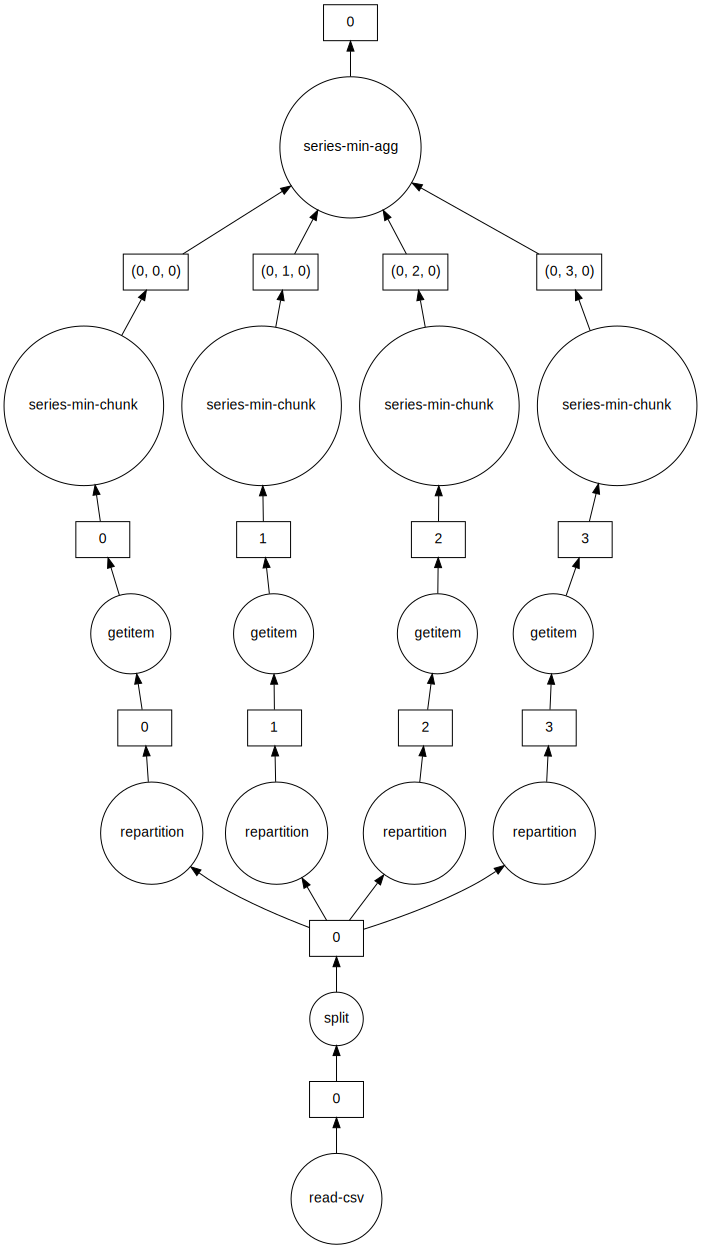

In [7]:
# Instead of getting the actual value we see dd.Scalar, which represents a recipe for actually calculating this value
last_eruption_year_min.visualize(format='svg')

In [23]:
# To get the value call the 'compute method'
# NOTE: this was slower than using pandas directly,,, for small data you often don't need to use parallel computing!
last_eruption_year_min.compute()

-10450.0

关于delayed计算,下一节会有更详细的介绍. 总之, 是先生成计算框架, 最后再并行执行计算.

## Dask Arrays

Dask数组看起来非常类似于numpy数组。但是，dask数组不会直接保存任何数据。相反，它象征性地表示生成数据所需的计算。在需要实际数值之前，不会实际计算任何内容。这种操作模式称为“lazy”。它允许人们在将其移交给调度程序执行之前，象征性地构建复杂的大型计算。

如果我们要创建一个所有数据为1的numpy数组，可以这样进行：

In [9]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

这个数据占据了32M的空间.

In [10]:
print('%.1f MB' % (ones_np.nbytes / 1e6))

32.0 MB


现在,让我们使用dask的array接口创建同样的数组

In [11]:
import dask.array as da
ones = da.ones(shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

现在我们还没有告诉 dask 如何拆分数组, 所以它还不能针对分布式计算进行优化.

Dask 和 numpy 数组一个关键的区别就是 在dask中我们必须指定chunks 参数. "Chunks"描述了 数组如何被分割成多个子数组.

![](pictures/dask-array-black-text.svg)

有多种指定 chunks 的方法. 比如 使用一个block shape:

In [12]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

注意，现在只是看到了数组的符号表示，包括其形状，dtype和chunksize。尚未生成任何数据。当我们对dask数组调用.compute()时，计算才被触发，dask数组变为numpy数组。

In [13]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

为了了解调用.compute()时发生的情况，我们可以可视化dask图（构成数组的符号操作）

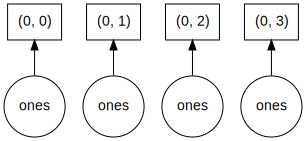

In [14]:
ones.visualize(format='svg')

数组有四个chunks。要生成它，dask调用np.ones四次，然后将其连接到一个数组中。

与其立即加载一个dask数组（将所有数据放入RAM），不如通过某种方式减少数据更为普遍。例如：

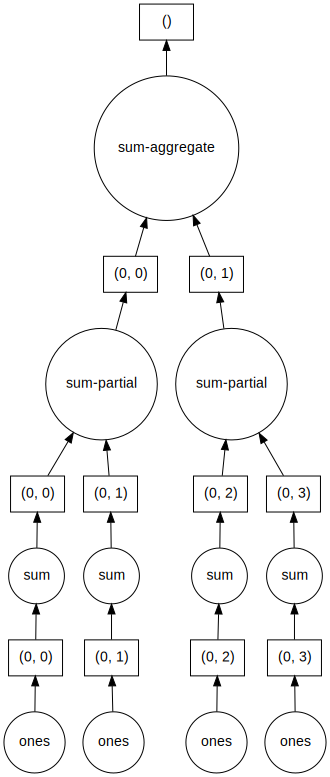

In [15]:
sum_of_ones = ones.sum()
sum_of_ones.visualize(format='svg')

在这里，我们看到了dask求和的策略。这个简单的示例说明了dask的漂亮之处：它自动设计了适合于大数据自定义操作的算法。

如果我们使操作更复杂，则图也将变得更复杂。

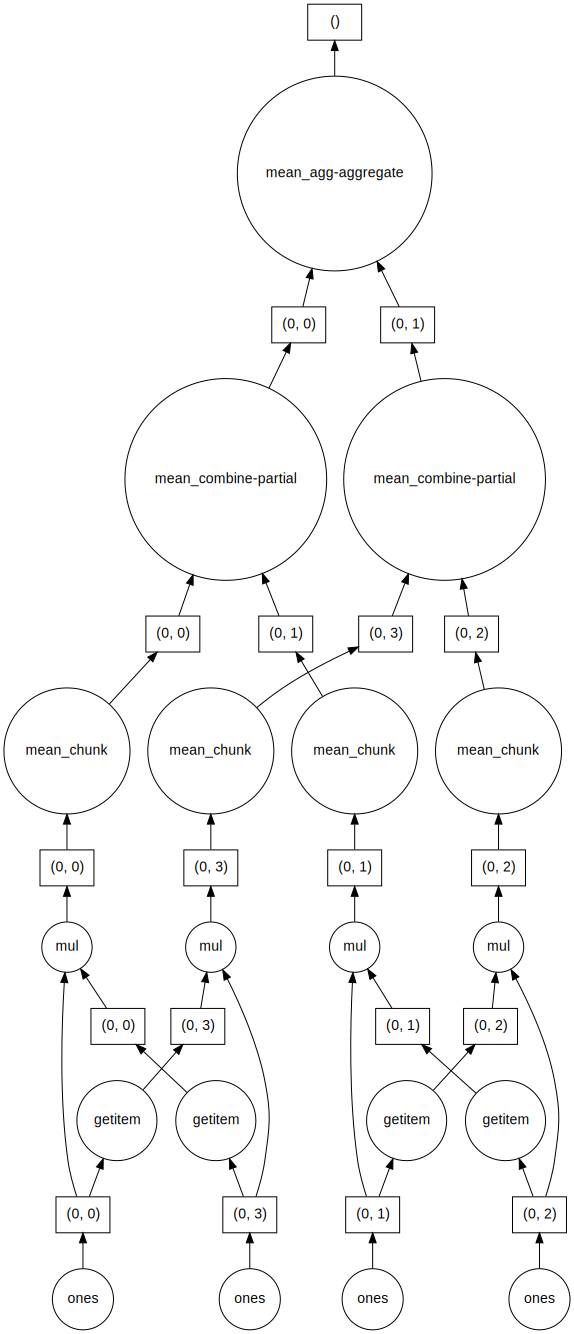

In [16]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize(format='svg')

现在看一个大数据的计算. 上面的例子是玩具的例子；数据（32 MB）远不足以保证使用dask。

我们可以做得更大！

In [17]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

dask.array<ones, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [18]:
print('%.1f MB' % (big_ones.nbytes / 1e6))

6400.0 MB


该数据集为6.4 GB，而不是32 MB！这可能接近或大于计算机中的可用RAM数量。不过，快速完成它没有问题。

*注意不要试图对这个数组进行.visualize（）！因为它太大了.*

进行大量计算时，注意查看仪表板来帮助我们了解幕后发生的事情。

In [19]:
big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

result = big_calc.compute()
result

1.0

所有常用的numpy方法都可以在dask数组上使用。也可以将numpy函数直接应用于dask数组，它将保持lazy状态。

In [20]:
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=1)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(200000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

因为我们需要实际值, 所以绘图也触发计算

In [21]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)

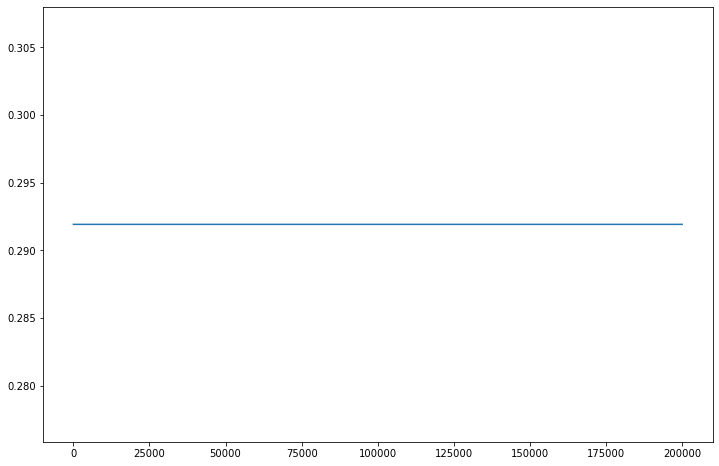

In [22]:
plt.plot(big_ones_reduce)

更多尝试后续逐渐补充.